# Flappy Bird Junco Sim
2D flight sim for EECE5500 Mobile Robotics

In [19]:
############################### Import libraries ###############################
import os
import glob
import time
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
from numpy import matlib

import gym
import control

In [34]:
class Drone():
    m = 3.2
    Iyy = 1/12*m*0.8**2

    S = 0.25
    c = 0.13

    Cl_0 = 0.5
    Cl_alpha = 0.17

    Cd_0 = 0.02
    K = 0.01

    Cm_0 = -0.05*0
    Cm_alpha = -0.2
    Cm_alpha_dot = -0.01
    Cm_delta_e = 0.2

    g = 9.81


    def __init__(self):
        self.x_thres = 10000
        self.z_thresHigh = 500
        self.z_thresLow = 0
        self.v_thres = 50
        self.theta_thres = np.pi/6
        self.theta_dot_thres = np.pi
        self.gamma_thres = np.pi/6
        self.alpha_dot_stale = 0

        self.limits = np.array([
            self.x_thres,
            self.z_thresHigh,
            self.z_thresLow,
            self.v_thres,
            self.theta_thres,
            self.theta_dot_thres,
            self.gamma_thres
        ])

        self.state = None
        self.prev_action = None
        self.steps_beyond_terminated = None

        self.time = 0.
        self.dt = 0.01

      
    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        
        self.time += self.dt

        #Extra states
        x, z, v, theta, theta_dot, gamma = self.state
        rho = np.random.normal(1.225,0.01)
        alpha = theta - gamma
        q = 0.5*rho*v**2
        
        #Control inputs
        thrust, delta_e = action

        # Forces
        Cl = self.Cl_0 + self.Cl_alpha*alpha
        Cd = self.Cd_0 + self.K*Cl**2
        Cm = self.Cm_0 + self.Cm_alpha*alpha + self.Cm_alpha_dot*self.alpha_dot_stale + self.Cm_delta_e*delta_e
        L = q*self.S*Cl
        D = q*self.S*Cd
        M = q*self.S*Cm

        #derivatives
        x_dot = v*np.cos(gamma)
        z_dot = v*np.sin(gamma)
        v_dot = (-D - self.m*self.g*np.sin(gamma) + thrust*np.cos(alpha)) / self.m
        #theta_dot = theta_dot
        theta_ddot = M / self.Iyy
        gamma_dot = (L - self.m*self.g*np.cos(gamma) +thrust*np.sin(alpha)) / (self.m*v)

        #No algebraic loops in my flight code 
        self.alpha_dot_stale = theta_dot - gamma_dot

        # integrate
        x += x_dot*self.dt
        z += z_dot*self.dt
        v += v_dot*self.dt
        theta += theta_dot*self.dt #Removed second order terms.  We don't do that here (Also needs to be 1/2dt^2 f"(t))
        theta_dot += theta_ddot * self.dt
        gamma += gamma_dot*self.dt

        state = np.array([x,z,v,theta,theta_dot,gamma])
        action = np.array([thrust,delta_e])

        self.state = (list(np.reshape(state,(6,))))

        terminated = bool(
            x < -self.x_thres
            or x > self.x_thres
            or z > self.z_thresHigh
            or z < self.z_thresLow
            or v < -self.v_thres
            or v > self.v_thres
            or theta < -self.theta_thres
            or theta > self.theta_thres
            or theta_dot < -self.theta_dot_thres
            or theta_dot > self.theta_dot_thres
            or gamma < -self.gamma_thres
            or gamma > self.gamma_thres
        )

        if not terminated:
            reward = 1.0
        elif self.steps_beyond_terminated is None:
            self.steps_beyond_terminated = 0
            reward = 0.0
        else:
            if self.steps_beyond_terminated == 0:
                print(self.state)
                gym.logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_terminated += 1
            reward = 0.0

        return state, reward, terminated, False

    def reset(self):
        self.state = np.array([0,100,20,0,0,0])
        self.steps_beyond_terminated = None
        self.time = 0

        return self.state

    def close(self):
        pass

/tmp/ipykernel_8792/4182276420.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


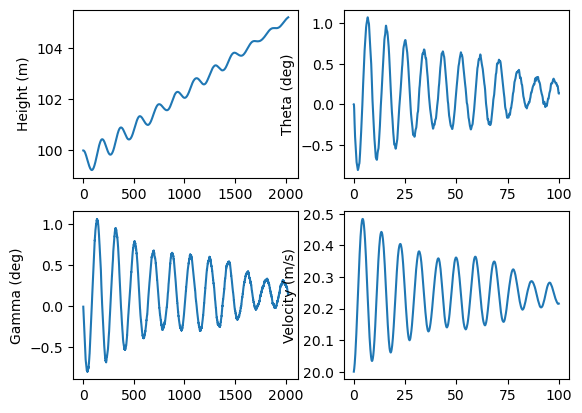

In [43]:
env = Drone()
state = env.reset()
action = np.array([1.5,0])
fig, axs = plt.subplots(2, 2)
trajx = []
trajz = []
trajtheta = []
trajgamma = []
trajv = []
trajt = []

for t in range(1, 10000):
    state, reward, done, _ = env.step(action)
    time = env.time
    x = state[0]
    z = state[1]
    v = state[2]
    theta = state[3]
    theta_dot = state[4]
    gamma = state[5]
    trajx.append(x)
    trajz.append(z)
    trajtheta.append(theta)
    trajgamma.append(gamma)
    trajv.append(v)
    trajt.append(time)

trajx = np.array(trajx)
trajz = np.array(trajz)
trajtheta = np.array(trajtheta)
trajgamma = np.array(trajgamma)
trajv = np.array(trajv)
trajt = np.array(trajt)

axs[0, 0].plot(trajx, trajz)
axs[0, 0].set_ylabel("Height (m)")
axs[0, 1].plot(trajt, trajtheta*180/np.pi)
axs[0, 1].set_ylabel("Theta (deg)")
axs[1, 0].plot(trajx, trajgamma*180/np.pi)
axs[1, 0].set_ylabel("Gamma (deg)")
axs[1, 1].plot(trajt, trajv)
axs[1, 1].set_ylabel("Velocity (m/s)")

fig.show()

In [ ]:
#################################### Testing ###################################

env = Drone()
state = env.reset()
action = np.array([1.5,1])

%matplotlib qt
fig, ax = plt.subplots(1,figsize=(10,5))
traj = []

for t in range(1, 1000):
    
    state, reward, done, _ = env.step(action)
    x = state[0]
    z = -state[1]
    v = state[2]
    theta = -state[3]
    theta_dot = -state[4]
    gamma = state[5]
    traj.append((x,z))

    action = np.array([0,0])
        
    if v<25:
        action[0] = 200
    else:
        action[0] = 0
        
    l = 0.8
    plt.plot([x,x+0.25*l*np.cos(theta)],[z,z+0.25*l*np.sin(theta)],'k-')
    plt.plot([x,x-0.75*l*np.cos(theta)],[z,z-0.75*l*np.sin(theta)],'k-')
    plt.xlim(x-20,x+80)
    plt.ylim(z-25,z+25)

    beam = 50
    angle = 60*np.pi/180
    plt.plot([x,x+beam*np.cos(theta+angle/2)],[z,z+beam*np.sin(theta+angle/2)],'k--')
    plt.plot([x,x+beam*np.cos(theta-angle/2)],[z,z+beam*np.sin(theta-angle/2)],'k--')
    xs = x+beam*np.cos(theta+np.linspace(-angle/2,angle/2,10))
    zs = z+beam*np.sin(theta+np.linspace(-angle/2,angle/2,10))
    plt.plot(xs,zs,'k.',markersize=1)

    x,z = zip(*traj)
    plt.plot(x,z,'b-',markersize=1)
    
    plt.show()
    plt.pause(env.dt)

    
    if done:
        break
    else:
        ax.clear()
print(np.around(state,2), reward, done)
env.close()